Log Processing
===============

Log files will be in CFL (Apache Common Log Format) example:

127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839

In [5]:
# This Block reads the LOG and parses de Apache Log into a RDD
# You can skip this to the description of the RDD in the cell below
# It's just parsing
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

In [7]:
# You can ignore this cell too

import sys
import os

logFile = ('data/apache/apache.access.log.PROJECT')

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Read 1043177 lines, successfully parsed 1043177 lines, failed to parse 0 lines


Rows
----------

Here we introduce spark Row objects and we show the structure of our RDD.

In [8]:
# Introducing Rows (A higher level RDD)
row = Row(name="Alice", age=11)
print row
print row.name, row.age
print "-------"
# Our RDD named access_logs is a RDD of Row objects, each Row object has the following fields:
a_row = access_logs.take(1)
print a_row
print "host: "+a_row[0].host
print "client_identd :"+a_row[0].client_identd
print "user_id: "+a_row[0].user_id
print "date_time: "+str(a_row[0].date_time)
print "method: "+a_row[0].method
print "endpoint: "+a_row[0].endpoint
print "protocol: "+a_row[0].protocol
print "response_code: "+str(a_row[0].response_code)
print "content_size: "+str(a_row[0].content_size)

Row(age=11, name='Alice')
Alice 11
-------
[Row(client_identd=u'-', content_size=1839L, date_time=datetime.datetime(1995, 8, 1, 0, 0, 1), endpoint=u'/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', host=u'in24.inetnebr.com', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-')]
host: in24.inetnebr.com
client_identd :-
user_id: -
date_time: 1995-08-01 00:00:01
method: GET
endpoint: /shuttle/missions/sts-68/news/sts-68-mcc-05.txt
protocol: HTTP/1.0
response_code: 200
content_size: 1839


Analyzing Content Size
-------------

[1839L]
Content Size Avg: 17531, Min: 0, Max: 3421948


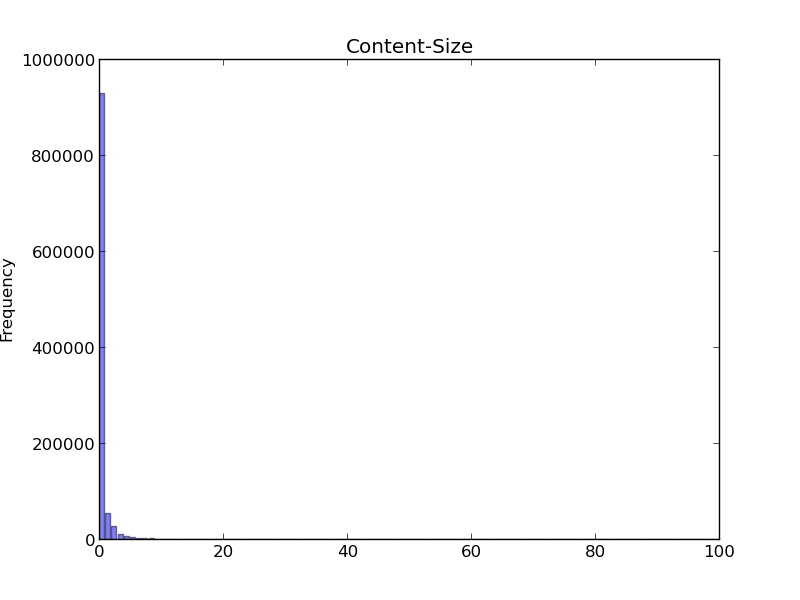

In [9]:
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print content_sizes.take(1)
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())
# Create an histogram
hist = content_sizes.histogram(100)

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
plt.close()
plt.clf()

y_pos = np.arange(len(hist[0][1:]))
plt.bar(y_pos, hist[1], alpha=0.5)
#plt.xticks(y_pos, my_words)
plt.ylabel('Frequency')
plt.title('Content-Size')
 
plt.savefig('content_size_histogram.png')
Image("content_size_histogram.png")

Top 10 Endpoints sorted by content-size:
---------------------------------------
1. /statistics/1995/Jul/Jul95_reverse_domains.html: 3421948
2. /shuttle/missions/sts-67/sounds/DurranceST.wav: 1188908
3. /shuttle/missions/sts-71/movies/sts-71-launch.mpg: 1121554
4. /shuttle/missions/sts-71/movies/sts-71-hatch-hand-group.mpg: 1081049
5. /shuttle/movies/astronauts.mpg: 1065779
6. /shuttle/missions/sts-26/movies/sts-26-launch.mpg: 1043093
7. /shuttle/missions/sts-70/movies/sts-70-landing.mpg: 952257
8. /shuttle/missions/sts-71/movies/sts-71-tcdt-crew-walkout.mpg: 887988
9. /shuttle/missions/sts-67/sounds/PariseRA.wav: 861740
10. /msfc/crew/parise.wav: 861740


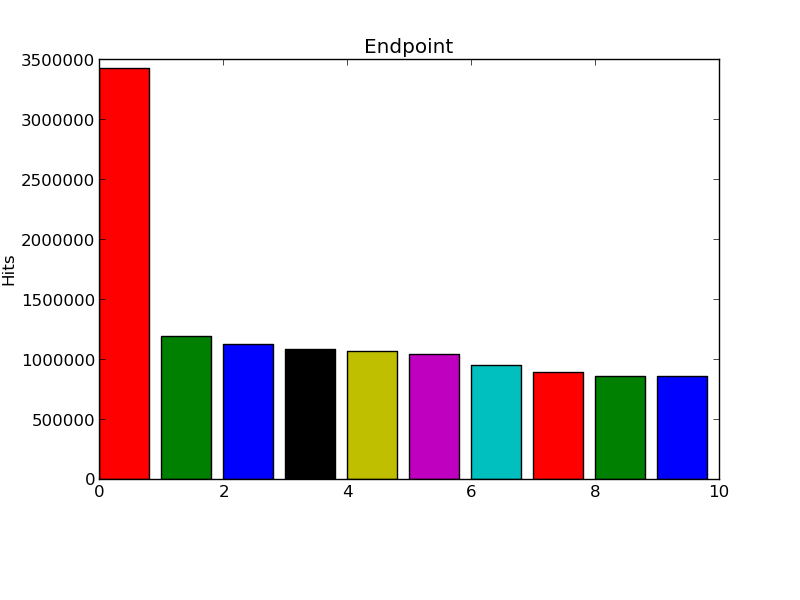

In [10]:
# Find the top highest endpoints in content-size
big_endpoints= access_logs.map(lambda log: (log.endpoint,log.content_size)).reduceByKey(lambda x,y:x).takeOrdered(10,lambda x:-x[1])
print "Top 10 Endpoints sorted by content-size:"
print "---------------------------------------"
i=0
for url in big_endpoints:
    i+=1
    print str(i)+'. '+url[0]+': '+str(url[1])

my_codes = [i for i,j in big_endpoints]
my_count = [j for i,j in big_endpoints]

plt.close()
plt.clf()
#fig = plt.figure(figsize=(8,13.5), facecolor='white', edgecolor='white')
my_colors = 'rgbkymc'  #red, green, blue, black, etc.
h = plt.bar(xrange(len(my_codes)), my_count, label=my_codes,color=my_colors)
plt.subplots_adjust(bottom=0.2)
#xticks_pos = [0.35*patch.get_width() + patch.get_xy()[0] for patch in h]
#plt.xticks(xticks_pos, my_codes,  ha='right', rotation=90)

plt.ylabel('Hits')
plt.title('Endpoint')

plt.savefig('big_endpoints.png')
Image("big_endpoints.png")

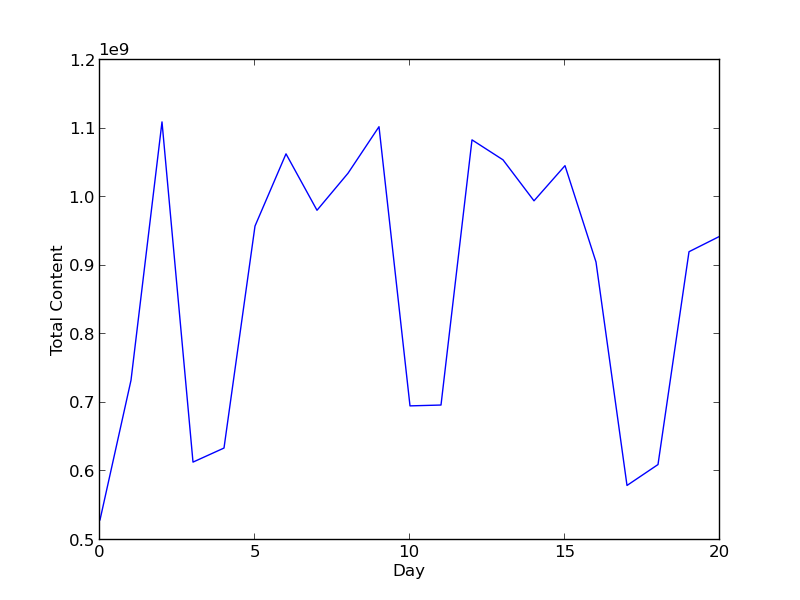

In [11]:
# Analize total-content size per day
# First convert records into (date,content_size)
days_content = (access_logs.map(lambda log:(int(str(log.date_time.year)+str(log.date_time.month).zfill(2)+str(log.date_time.day).zfill(2)),log.content_size))
                .reduceByKey(lambda x,y:x+y).takeOrdered(100))

my_days = [i for i,j in days_content]
my_bytes = [j for i,j in days_content]

plt.close()
plt.clf()
#fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
#plt.axis([min(my_days), max(my_days), 0, max(my_bytes)])
#plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Total Content')
#plt.plot(my_days, my_bytes)
h = plt.plot(xrange(len(my_days)), my_bytes, label=my_days)
#xticks_pos = [patch.get_width() + patch.get_xy()[0] for patch in h]
#plt.xticks(xticks_pos, my_days,  ha='right', rotation=45)
plt.savefig('content_by_day.png')
Image("content_by_day.png")

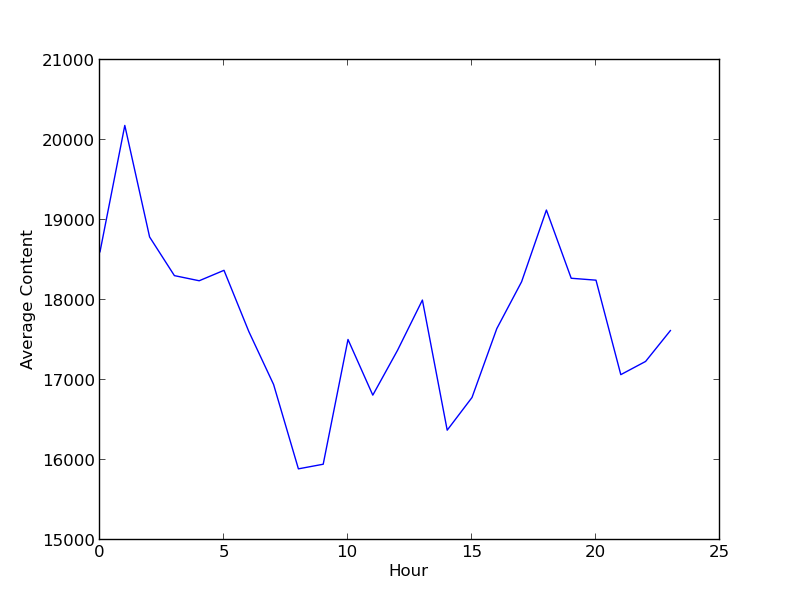

In [12]:
# Average Content-Size per hour of day
hour_content = (access_logs.map(lambda log:(log.date_time.hour,(log.content_size,1)))
                           .reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1]))
                           .map(lambda x:(x[0],float(x[1][0])/x[1][1]))
                           .takeOrdered(24))

my_days = [i for i,j in hour_content]
my_bytes = [j for i,j in hour_content]

plt.close()
plt.clf()
plt.xlabel('Hour')
plt.ylabel('Average Content')
h = plt.plot(xrange(len(my_days)), my_bytes)
plt.savefig('content_by_hour.png')
Image("content_by_hour.png")

Endpoints 
---------

In [17]:
# endpoints that are accessed most often
top_endpoints = access_logs.map(lambda log:(log.endpoint,1)).countByKey()
#reduceByKey(lambda x,y:x+y).takeOrdered(20,lambda x:-x[1])
print top_endpoints['/']
#print "Top 20 endpoints by number of hits"
#print "----------------------------------"
#i = 0 
#for endpoint in top_endpoints:
#    i+=1
#    print str(i)+". "+endpoint[0]+": "+str(endpoint[1])
    

20292


Response Codes
--------------

Found 7 response codes
200: 940847
304: 79824
404: 6185
500: 2
501: 17
302: 16244
403: 58
[200, 304, 404, 500, 501, 302, 403]
[940847, 79824, 6185, 2, 17, 16244, 58]


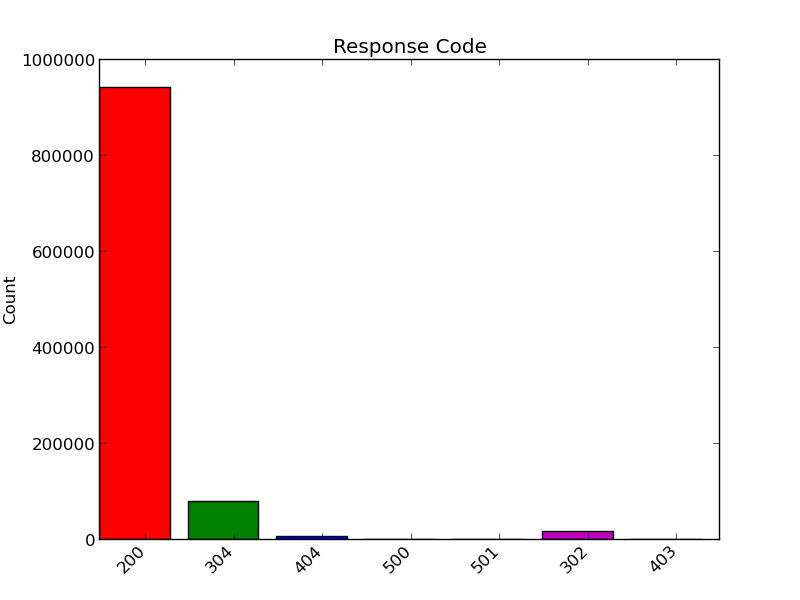

In [18]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b))
responseCodeToCountList = responseCodeToCount.collect()
print 'Found %d response codes' % len(responseCodeToCountList)
for code in responseCodeToCountList:
    print str(code[0])+": "+str(code[1])
    
my_codes = [i for i,j in responseCodeToCountList]
my_count = [j for i,j in responseCodeToCountList]

print my_codes
print my_count

plt.close()
plt.clf()
my_colors = 'rgbkymc'  #red, green, blue, black, etc.
h = plt.bar(xrange(len(my_codes)), my_count, label=my_codes,color=my_colors)
#plt.subplots_adjust(bottom=0.3)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, my_codes,  ha='right', rotation=45)

plt.ylabel('Count')
plt.title('Response Code')

plt.savefig('response_codes.png')
Image("response_codes.png")

In [19]:
# We want to check those pesky 404 error codes
notFound = (access_logs.filter(lambda log:log.response_code==404)
                       .map(lambda log:(log.endpoint,1))
                       .reduceByKey(lambda x,y:x+y)
                       .takeOrdered(20,lambda x:-x[1]))
print "Top 20 404 endpoints"
print "--------------------"
for nf in notFound:
    print nf[0]+': '+str(nf[1])
    

Top 20 404 endpoints
--------------------
/pub/winvn/readme.txt: 633
/pub/winvn/release.txt: 494
/shuttle/missions/STS-69/mission-STS-69.html: 431
/images/nasa-logo.gif: 319
/elv/DELTA/uncons.htm: 178
/shuttle/missions/sts-68/ksc-upclose.gif: 156
/history/apollo/sa-1/sa-1-patch-small.gif: 146
/images/crawlerway-logo.gif: 120
/://spacelink.msfc.nasa.gov: 117
/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif: 100
/history/apollo/a-001/a-001-patch-small.gif: 97
/images/Nasa-logo.gif: 85
/shuttle/resources/orbiters/atlantis.gif: 64
/history/apollo/images/little-joe.jpg: 62
/images/lf-logo.gif: 59
/shuttle/resources/orbiters/discovery.gif: 56
/shuttle/resources/orbiters/challenger.gif: 54
/robots.txt: 53
/elv/new01.gif>: 43
/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif: 38


Hosts
------

In [ ]:
# Top Hosts
hosts = (access_logs.map(lambda log:(log.host,1))
                    .reduceByKey(lambda x,y:x+y)
                    .takeOrdered(20,lambda x:-x[1]))
print "Top 20 Hosts:"
print "-------------"
i=0
for host in hosts:
    i+=1
    print str(i)+". "+host[0]+": "+str(host[1])

Specific Queries
----------------